# Invoice Late Payment Prediction
**Author:** Will Martin  
**Date:** January 31, 2026  

## Project Objective
Predict the likelihood of late payment on invoices using machine learning to enable proactive collection strategies and improve cash flow management.

## Business Problem
Late invoice payments create cash flow disruptions, increase collection costs, and limit working capital. By identifying high-risk invoices early, businesses can send automated reminders, prioritize collection efforts, and adjust credit terms for chronically late customers.

## Dataset Overview
- Source: IBM Watson Analytics - Accounts Receivable Sample
- Size: 2,586 invoices
- Time Period: 2012-2013
- Target: Binary classification (Late vs On-Time payment)

---

## Table of Contents
1. Data Loading and Initial Exploration
2. Data Preprocessing
3. Exploratory Data Analysis
4. Feature Engineering and Model Preparation
5. Model Development
6. Model Evaluation and Comparison

---


## 1. Data Loading and Initial Exploration

The first step is to load the accounts receivable dataset and perform initial data quality checks. This includes examining the dataset structure, identifying data types, and spotting potential issues before preprocessing.


### 1.1 Import Required Libraries

Loading the necessary Python libraries for data manipulation, visualization, statistical analysis, and machine learning.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

### 1.2 Connect to Data Source

Mounting Google Drive to access the dataset stored in cloud storage.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/IBM_Invoice/WA_Fn-UseC_-Accounts-Receivable.csv')

### 1.3 Initial Data Exploration

Examining the dataset to understand its structure, variable types, and  properties. This includes checking the number of observations and features, identifying data types, reviewing summary statistics, and looking for missing values.


In [5]:
df.head(5)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,818,6627-ELFBK,11/26/2012,2195380883,1/6/2012,2/5/2012,47.07,Yes,2/3/2012,Paper,28,0
1,897,9174-IYKOC,NaN,136962706,8/7/2013,9/6/2013,92.67,No,9/13/2013,NaN,37,7
2,770,0706-NRGUP,4/9/2013,2238525299,10/5/2013,11/4/2013,35.70,No,10/26/2013,Electronic,21,0
3,770,2026-XLBER,11/12/2012,1678077270,4/24/2012,5/24/2012,60.93,No,5/12/2012,Paper,18,0
4,391,3569-VJWXS,4/9/2013,3242588970,5/15/2013,6/14/2013,35.23,No,6/7/2013,Electronic,23,0


In [6]:
df.describe()

,countryCode,invoiceNumber,InvoiceAmount,DaysToSettle,DaysLate
count,2586.000000,2.586000e+03,2586.000000,2586.000000,2586.000000
mean,621.739753,4.752472e+09,60.192877,26.659706,3.674787
std,215.769020,2.997101e+09,20.691961,12.702252,6.604596
min,391.000000,6.113650e+05,5.260000,0.000000,0.000000
25%,406.000000,2.123741e+09,46.392500,18.000000,0.000000
50%,770.000000,4.753321e+09,60.605000,26.000000,0.000000
75%,818.000000,7.360784e+09,74.067500,35.000000,5.000000
max,897.000000,9.990244e+09,128.280000,75.000000,45.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2586 entries, 0 to 2585
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryCode    2586 non-null   int64  
 1   customerID     2586 non-null   object 
 2   PaperlessDate  2466 non-null   object 
 3   invoiceNumber  2586 non-null   int64  
 4   InvoiceDate    2586 non-null   object 
 5   DueDate        2586 non-null   object 
 6   InvoiceAmount  2586 non-null   float64
 7   Disputed       2586 non-null   object 
 8   SettledDate    2586 non-null   object 
 9   PaperlessBill  2466 non-null   object 
 10  DaysToSettle   2586 non-null   int64  
 11  DaysLate       2586 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 242.6+ KB


### 1.4 Data Type Adjustments and Column Removal

Date columns are first converted to datetime format so they can be used for time-based analysis and feature creation. Some columns are then removed to keep the data realistic for prediction. The invoiceNumber column is dropped because it is just a unique ID and does not add any predictive value, and DueDate is removed since it can be derived if needed. Most importantly, SettledDate is excluded due data leakage.

In [8]:
date_cols = ['PaperlessDate',	'InvoiceDate', 'DueDate', 'SettledDate']
df[date_cols] = df[date_cols].apply(pd.to_datetime)

In [9]:
drop_cols = ['invoiceNumber', 'SettledDate','DueDate']

print(f"Columns to drop due to being unique identifiers: {drop_cols}")
df = df.drop(columns=drop_cols, errors='ignore')

Columns to drop due to being unique identifiers: ['invoiceNumber', 'SettledDate', 'DueDate']


---

## 2. Data Preprocessing

The goal of this section is to clean and prepare the dataset for analysis by handling data quality issues and preparing features for modeling. This includes missing value treatment, outlier detection, correlation analysis, target variable creation, and feature engineering from dates.


### 2.1 Missing Value Analysis and Treatment

Missing data is identifying and removed from the dataset. After handling missing values, verify completeness by confirming no remaining missing values and documenting how many rows were removed.


In [10]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing Values Inspection:")
display(missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))

Missing Values Inspection:


,Missing Count,Missing Percentage
PaperlessDate,120,4.640371
PaperlessBill,120,4.640371


In [11]:
df_cleaned = df.dropna()

display(df_cleaned.head(5))

,countryCode,customerID,PaperlessDate,InvoiceDate,InvoiceAmount,Disputed,PaperlessBill,DaysToSettle,DaysLate
0,818,6627-ELFBK,2012-11-26,2012-01-06,47.07,Yes,Paper,28,0
2,770,0706-NRGUP,2013-04-09,2013-10-05,35.70,No,Electronic,21,0
3,770,2026-XLBER,2012-11-12,2012-04-24,60.93,No,Paper,18,0
4,391,3569-VJWXS,2013-04-09,2013-05-15,35.23,No,Electronic,23,0
5,897,3271-YDPUJ,2013-04-02,2012-04-08,76.71,Yes,Paper,47,17


In [12]:
missing_values_cleaned = df_cleaned.isnull().sum()
missing_percentage_cleaned = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

missing_info_cleaned = pd.DataFrame({
    'Missing Count': missing_values_cleaned,
    'Missing Percentage': missing_percentage_cleaned})

print("Missing Values Inspection after dropping:")
display(missing_info_cleaned[missing_info_cleaned['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))

Missing Values Inspection after dropping:


,Missing Count,Missing Percentage


### 2.2 Outlier Detection and Removal

Outliers are identified using Z-score analysis with a threshold of |Z| > 3, meaning values more than three standard deviations from the mean are flagged as extreme. This approach is applied to InvoiceAmount to capture unusually high or low invoice values and to DaysToSettle to identify abnormally fast or slow payment times. Removing these extreme values helps prevent them from disproportionately influencing model training and improves overall generalization, while still retaining roughly 96% of the original data. The DaysLate variable is intentionally excluded from outlier removal since it is used to construct the target variable.


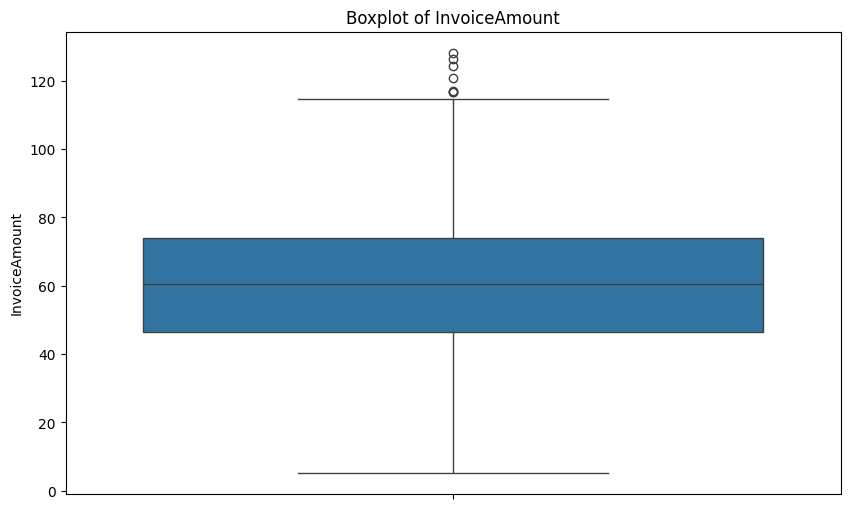

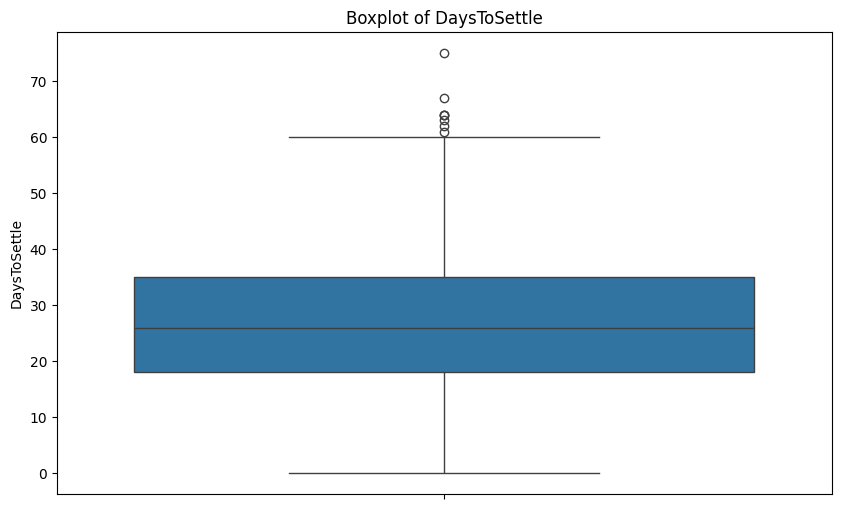

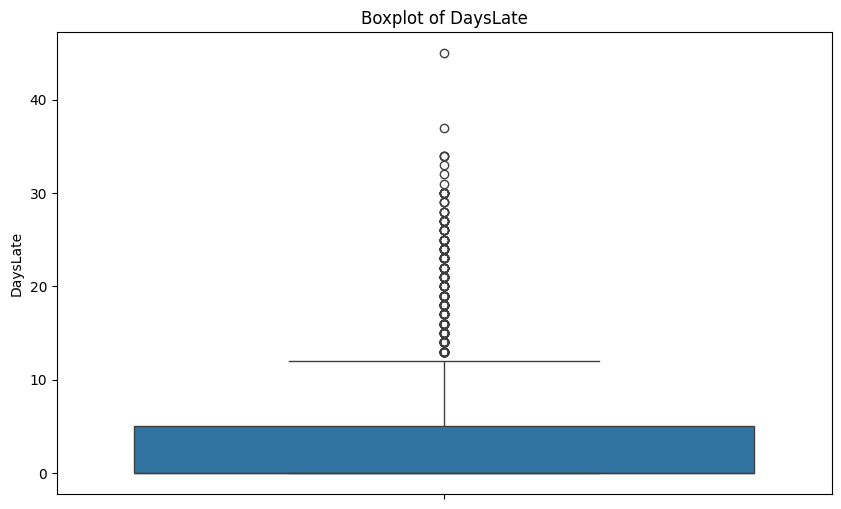

In [13]:
num_cols = ['InvoiceAmount', 'DaysToSettle', 'DaysLate']

for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

In [14]:
num_cols.remove('DaysLate')

In [15]:
outlier_counts = {}
threshold = 3

for col in num_cols:
    z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))
    outliers = z_scores[~np.isnan(z_scores)] > threshold
    outlier_counts[col] = np.sum(outliers)

print("Number of outliers per numerical feature (Z-score > 3):")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

Number of outliers per numerical feature (Z-score > 3):
InvoiceAmount: 3
DaysToSettle: 2


In [16]:
z_scores = np.abs(stats.zscore(df[num_cols], nan_policy='omit'))

threshold = 3

rows_to_keep = (z_scores < threshold).all(axis=1)

before_count = df.shape[0]
df_clean = df[rows_to_keep].copy()
after_count = df_clean.shape[0]

print(f"Outlier removal complete:")
print(f"Rows before: {before_count}")
print(f"Rows after:  {after_count}")
print(f"Rows removed: {before_count - after_count}")

Outlier removal complete:
Rows before: 2586
Rows after:  2581
Rows removed: 5


### 2.3 Target Variable Creation

Creating a binary classification target variable where IsLate equals 1 if DaysLate is greater than 0 (invoice paid after due date) and IsLate equals 0 if DaysLate equals 0 (invoice paid on time).

After creating the target variable, removing DaysLate because it directly reveals the target, and removing DaysToSettle because it is strongly correlated with the target.


In [17]:
df_model = df_cleaned.copy()

df_model['IsLate'] = np.where(df_cleaned['DaysLate'] > 0, 1, 0)
df_model.drop(columns=['DaysLate','DaysToSettle'], inplace=True)

df_model.head()

,countryCode,customerID,PaperlessDate,InvoiceDate,InvoiceAmount,Disputed,PaperlessBill,IsLate
0,818,6627-ELFBK,2012-11-26,2012-01-06,47.07,Yes,Paper,0
2,770,0706-NRGUP,2013-04-09,2013-10-05,35.70,No,Electronic,0
3,770,2026-XLBER,2012-11-12,2012-04-24,60.93,No,Paper,0
4,391,3569-VJWXS,2013-04-09,2013-05-15,35.23,No,Electronic,0
5,897,3271-YDPUJ,2013-04-02,2012-04-08,76.71,Yes,Paper,1


### 2.4 Correlation Analysis
The correlation analysis highlights a strong relationship between payment timing variables, with DaysToSettle and DaysLate showing a high correlation, indicating they capture similar information about invoice payment behavior. In contrast, InvoiceAmount has only a weak relationship with both timing variables, suggesting that invoice size alone is not a strong driver of late payments. The correlation ratio analysis between numeric and categorical features shows that customer-level attributes explain a meaningful portion of variance in payment behavior, supporting the use of customer history features. Dispute status and paperless billing features show moderate associations, while country-level features contribute little predictive value.

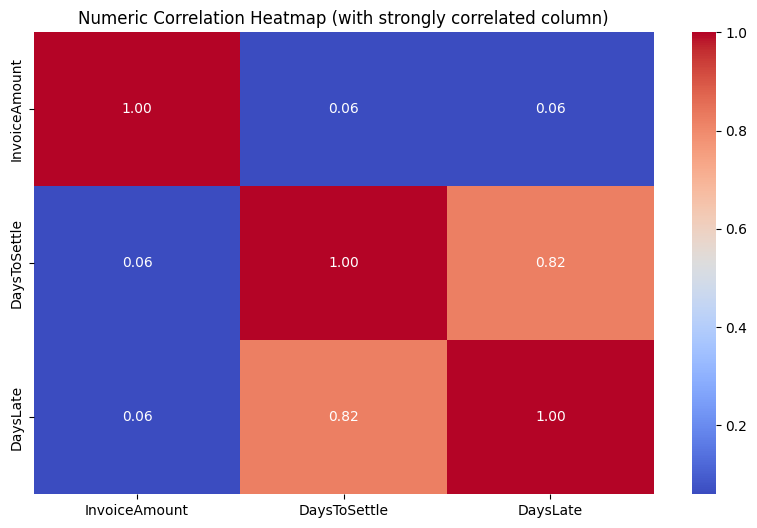

In [18]:
numeric_cols = ['InvoiceAmount', 'DaysToSettle', 'DaysLate']

corr = df_cleaned[numeric_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Numeric Correlation Heatmap (with strongly correlated column)")
plt.show()

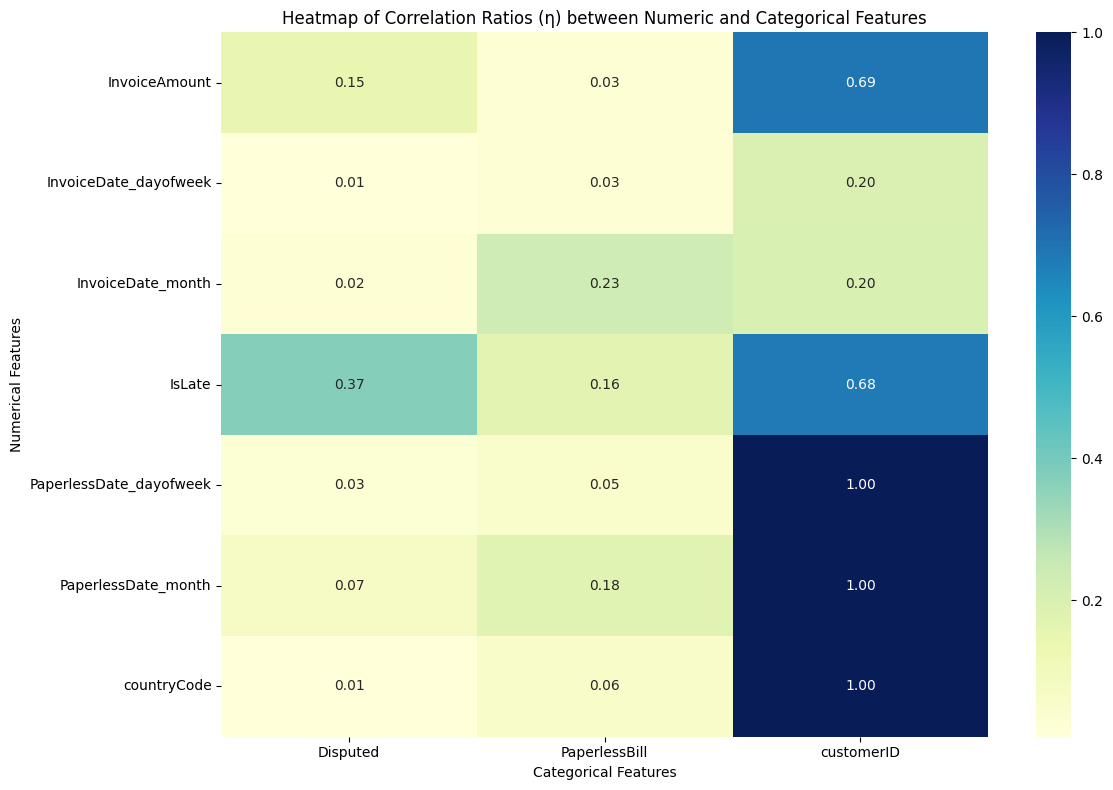

In [19]:
for col in ['PaperlessDate', 'InvoiceDate', 'DueDate', 'SettledDate']:
    if col in df_model.columns:
        df_model[f'{col}_month'] = df_model[col].dt.month
        df_model[f'{col}_dayofweek'] = df_model[col].dt.dayofweek

categorical_cols_clean = df_model.select_dtypes(include='object').columns.tolist()
numeric_cols_clean = df_model.select_dtypes(include=np.number).columns.tolist()

numeric_cols_for_eta = [col for col in numeric_cols_clean if col not in ['bounty', 'Approved']]
categorical_cols_for_eta = categorical_cols_clean.copy()

def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    cat_levels = np.unique(categories)
    overall_mean = np.mean(values)
    numerator = sum(len(values[categories == cat]) *
                    (np.mean(values[categories == cat]) - overall_mean) ** 2
                    for cat in cat_levels)
    denominator = sum((values - overall_mean) ** 2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

num_cat_results = []
for num_col in numeric_cols_for_eta:
    for cat_col in categorical_cols_for_eta:
        eta = correlation_ratio(df_model[cat_col], df_model[num_col])
        num_cat_results.append((num_col, cat_col, eta))

num_cat_results = sorted(num_cat_results, key=lambda x: x[2], reverse=True)

eta_matrix = pd.DataFrame(num_cat_results, columns=['Numerical_Feature', 'Categorical_Feature', 'Eta'])
eta_pivot = eta_matrix.pivot(index='Numerical_Feature', columns='Categorical_Feature', values='Eta')

plt.figure(figsize=(12, 8))
sns.heatmap(eta_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of Correlation Ratios (η) between Numeric and Categorical Features")
plt.xlabel("Categorical Features")
plt.ylabel("Numerical Features")
plt.tight_layout()
plt.show()


## Data Exploration

### 3.1 Target Variable Distribution

Analyzing the class balance is critical for selecting appropriate evaluation metrics, deciding if resampling techniques like SMOTE are needed, and setting realistic performance expectations.


/tmp/ipython-input-3638334387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='IsLate', data=df_model, palette='coolwarm')


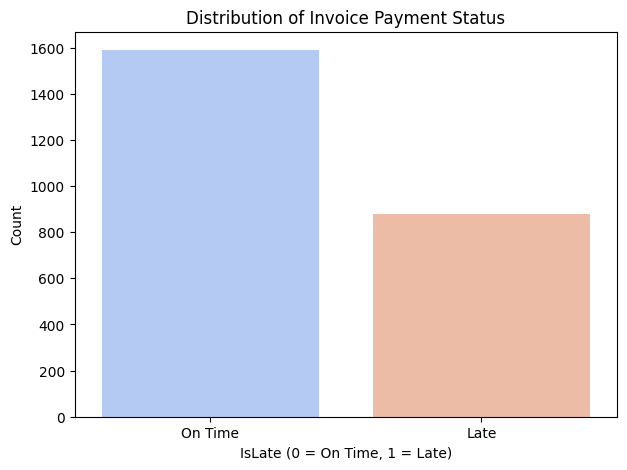

In [43]:
plt.figure(figsize=(7, 5))
sns.countplot(x='IsLate', data=df_model, palette='coolwarm')
plt.title('Distribution of Invoice Payment Status')
plt.xlabel('IsLate (0 = On Time, 1 = Late)')
plt.ylabel('Count')
plt.xticks([0, 1], ['On Time', 'Late'])
plt.show()

late_counts = df_model['IsLate'].value_counts()
late_percentages = df_model['IsLate'].value_counts(normalize=True) * 100

### 3.2 Temporal Trend Analysis

Examining whether late payment rates vary over time by tracking monthly trends and identifying seasonal patterns.

Understanding temporal patterns helps identify high-risk periods, plan proactive outreach campaigns, and adjust staffing for collection efforts.


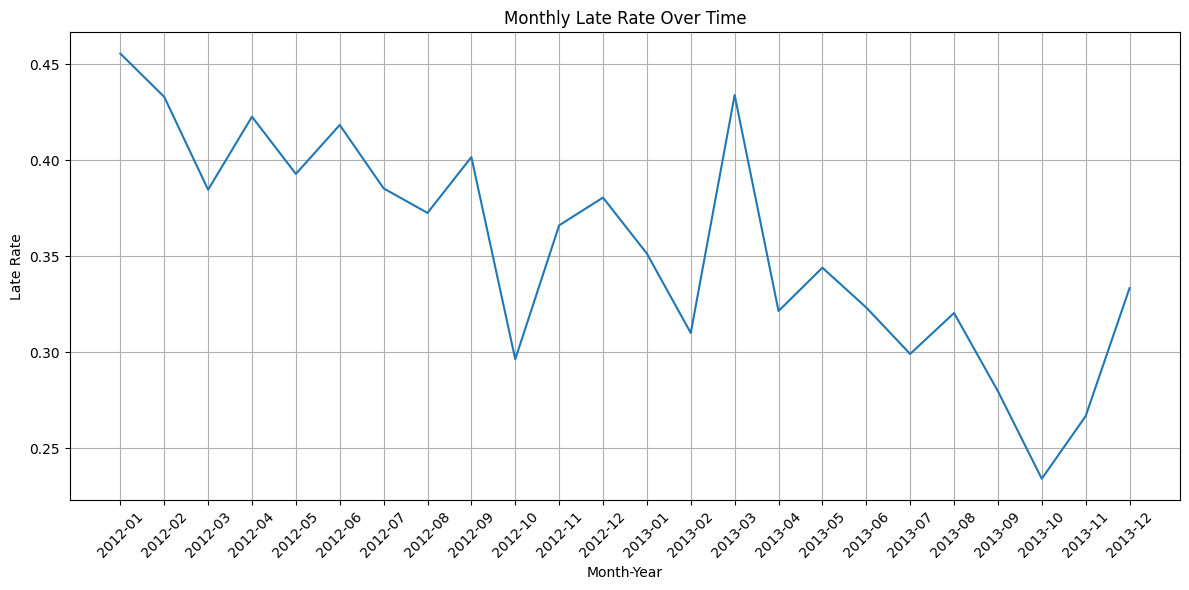

In [21]:
df_model['InvoiceDate'] = pd.to_datetime(df_model['InvoiceDate'])
df_model['InvoiceMonthYear'] = df_model['InvoiceDate'].dt.to_period('M')

monthly_late_rate = df_model.groupby('InvoiceMonthYear')['IsLate'].mean().reset_index()
monthly_late_rate['InvoiceMonthYear'] = monthly_late_rate['InvoiceMonthYear'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x='InvoiceMonthYear', y='IsLate', data=monthly_late_rate)
plt.title('Monthly Late Rate Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Late Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1597986400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='InvoiceMonthYear', y='IsLate', data=monthly_late_rate, palette='viridis')


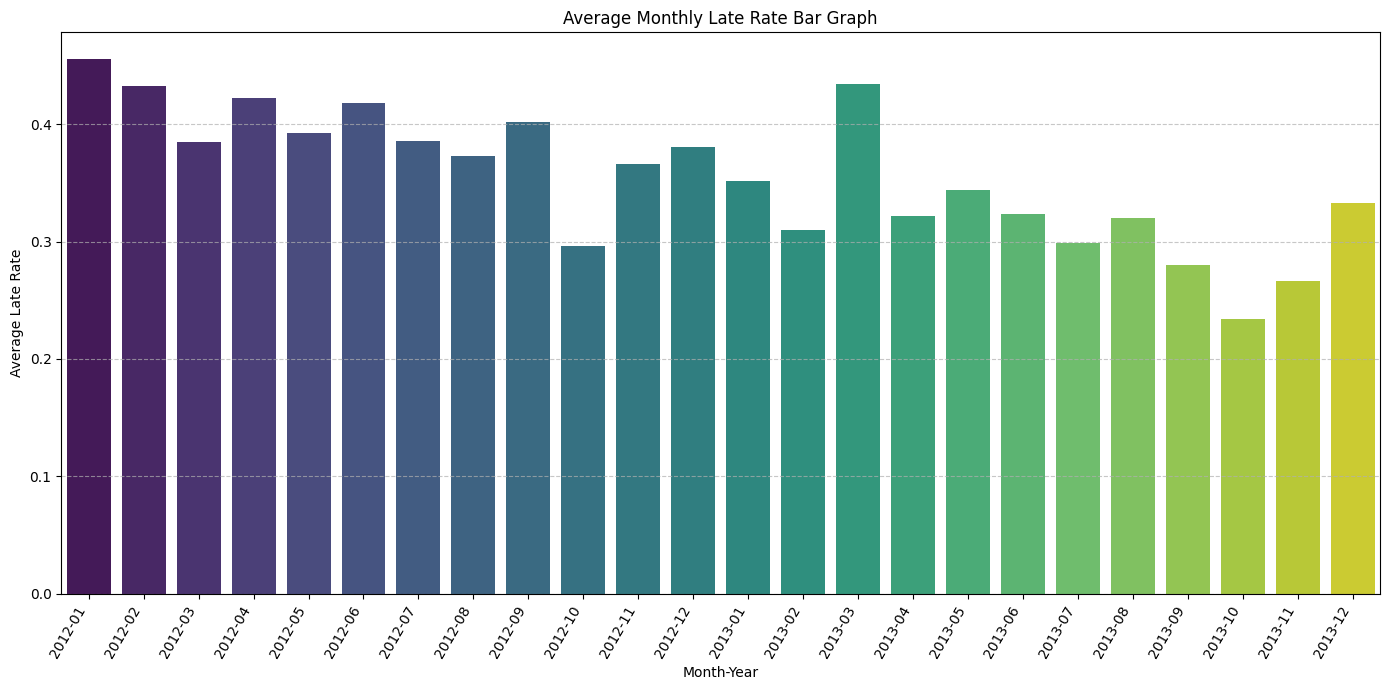

In [22]:
plt.figure(figsize=(14, 7))
sns.barplot(x='InvoiceMonthYear', y='IsLate', data=monthly_late_rate, palette='viridis')
plt.title('Average Monthly Late Rate Bar Graph')
plt.xlabel('Month-Year')
plt.ylabel('Average Late Rate')
plt.xticks(rotation=60, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2904811813.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='InvoiceMonth', y='IsLate', data=monthly_avg_late_rate, palette='viridis')


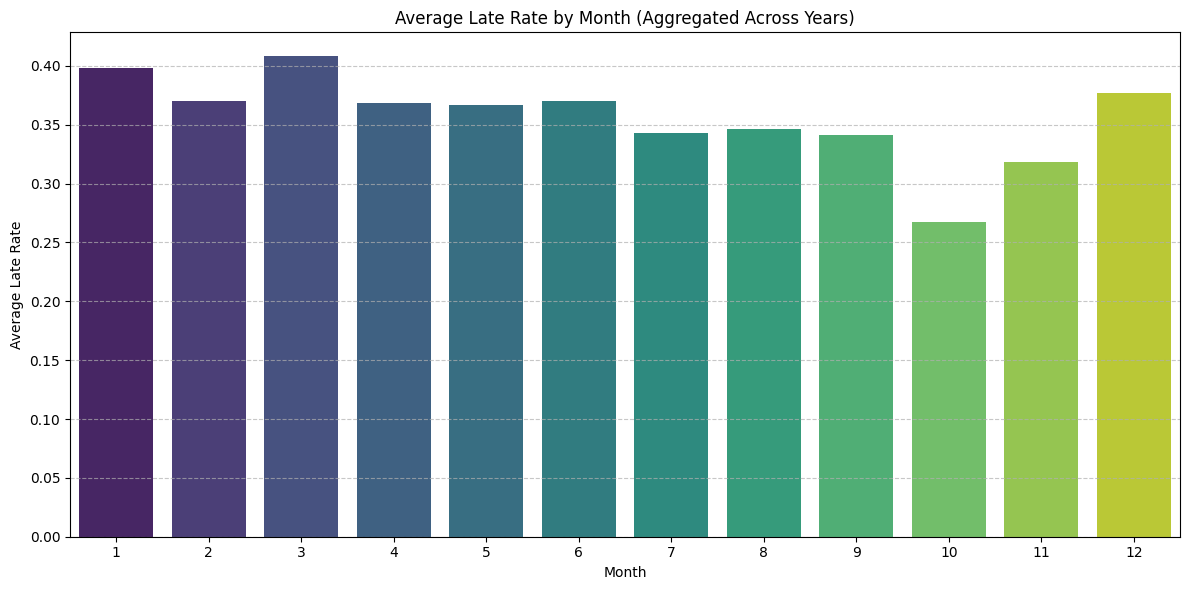

In [23]:
df_model['InvoiceMonth'] = df_model['InvoiceDate'].dt.month

monthly_avg_late_rate = df_model.groupby('InvoiceMonth')['IsLate'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='InvoiceMonth', y='IsLate', data=monthly_avg_late_rate, palette='viridis')
plt.title('Average Late Rate by Month (Aggregated Across Years)')
plt.xlabel('Month')
plt.ylabel('Average Late Rate')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.3 Paperless Billing Timing Analysis

Testing the hypothesis that the timing of paperless enrollment relative to invoice date affects payment behavior. The analysis creates bins for different enrollment timings: enrolled long before invoice (180+ days), enrolled shortly before invoice (0-30 days), and enrolled after invoice.

Customers who enroll in paperless billing after receiving an invoice may be more likely to miss the payment notification.


/tmp/ipython-input-1794049940.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_paperless_analysis, x='IsLate_label', y='days_paperless_to_invoice',


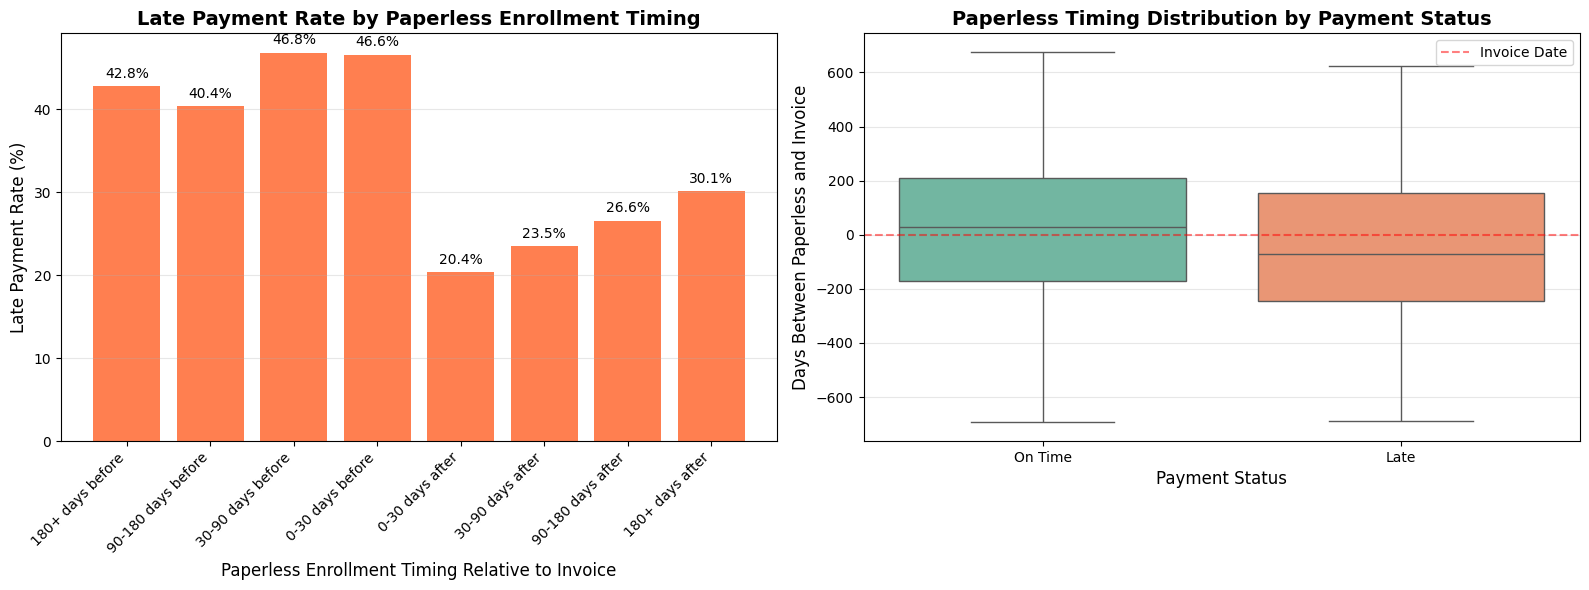

In [44]:
df_model['days_paperless_to_invoice'] = (df_model['InvoiceDate'] - df_model['PaperlessDate']).dt.days

df_paperless_analysis = df_model.dropna(subset=['days_paperless_to_invoice']).copy()

bins = [-np.inf, -180, -90, -30, 0, 30, 90, 180, np.inf]
labels = ['180+ days before', '90-180 days before', '30-90 days before',
          '0-30 days before', '0-30 days after', '30-90 days after',
          '90-180 days after', '180+ days after']
df_paperless_analysis['paperless_timing'] = pd.cut(df_paperless_analysis['days_paperless_to_invoice'],
                                                     bins=bins, labels=labels)

late_by_timing = df_paperless_analysis.groupby('paperless_timing', observed=True).agg({
    'IsLate': ['mean', 'sum', 'count']
}).reset_index()
late_by_timing.columns = ['Timing', 'LateRate', 'LateCases', 'TotalInvoices']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(range(len(late_by_timing)), late_by_timing['LateRate'] * 100, color='coral')
ax1.set_xticks(range(len(late_by_timing)))
ax1.set_xticklabels(late_by_timing['Timing'], rotation=45, ha='right')
ax1.set_ylabel('Late Payment Rate (%)', fontsize=12)
ax1.set_xlabel('Paperless Enrollment Timing Relative to Invoice', fontsize=12)
ax1.set_title('Late Payment Rate by Paperless Enrollment Timing', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(late_by_timing['LateRate'] * 100):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

df_paperless_analysis['IsLate_label'] = df_paperless_analysis['IsLate'].map({0: 'On Time', 1: 'Late'})
sns.boxplot(data=df_paperless_analysis, x='IsLate_label', y='days_paperless_to_invoice',
            palette='Set2', ax=ax2)
ax2.set_ylabel('Days Between Paperless and Invoice', fontsize=12)
ax2.set_xlabel('Payment Status', fontsize=12)
ax2.set_title('Paperless Timing Distribution by Payment Status', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Invoice Date')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.4 Day-of-Week Analysis

Testing if the day an invoice is sent affects late payment probability where invoices sent on Fridays are likely paid late (received near weekend). After analyzing the results, optimizing invoice delivery timing to minimize late payments.


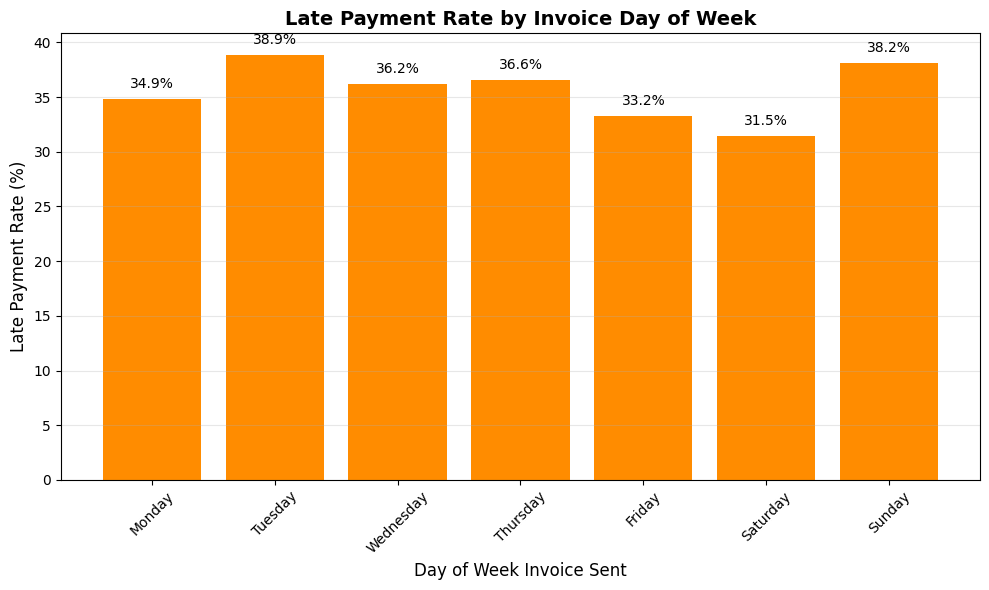

In [25]:
df_model['invoice_dayofweek_name'] = df_model['InvoiceDate'].dt.day_name()

late_by_dayofweek = df_model.groupby('invoice_dayofweek_name').agg({
    'IsLate': ['mean', 'sum', 'count']
}).reset_index()
late_by_dayofweek.columns = ['DayOfWeek', 'LateRate', 'LateCases', 'TotalInvoices']

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
late_by_dayofweek['DayOfWeek'] = pd.Categorical(late_by_dayofweek['DayOfWeek'],
                                                  categories=day_order, ordered=True)
late_by_dayofweek = late_by_dayofweek.sort_values('DayOfWeek')

plt.figure(figsize=(10, 6))
plt.bar(late_by_dayofweek['DayOfWeek'], late_by_dayofweek['LateRate'] * 100,
        color='darkorange')
plt.ylabel('Late Payment Rate (%)', fontsize=12)
plt.xlabel('Day of Week Invoice Sent', fontsize=12)
plt.title('Late Payment Rate by Invoice Day of Week', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

for i, (day, rate) in enumerate(zip(late_by_dayofweek['DayOfWeek'],
                                     late_by_dayofweek['LateRate'] * 100)):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 3.5 Billing Method Impact

Comparing payment behavior between customers with electronic billing versus paper billing. Electronic billing offers instant delivery but may be easier to miss, while paper billing provides a physical reminder but has slower delivery.

Understanding these differences helps guide billing method recommendations for high-risk customers.


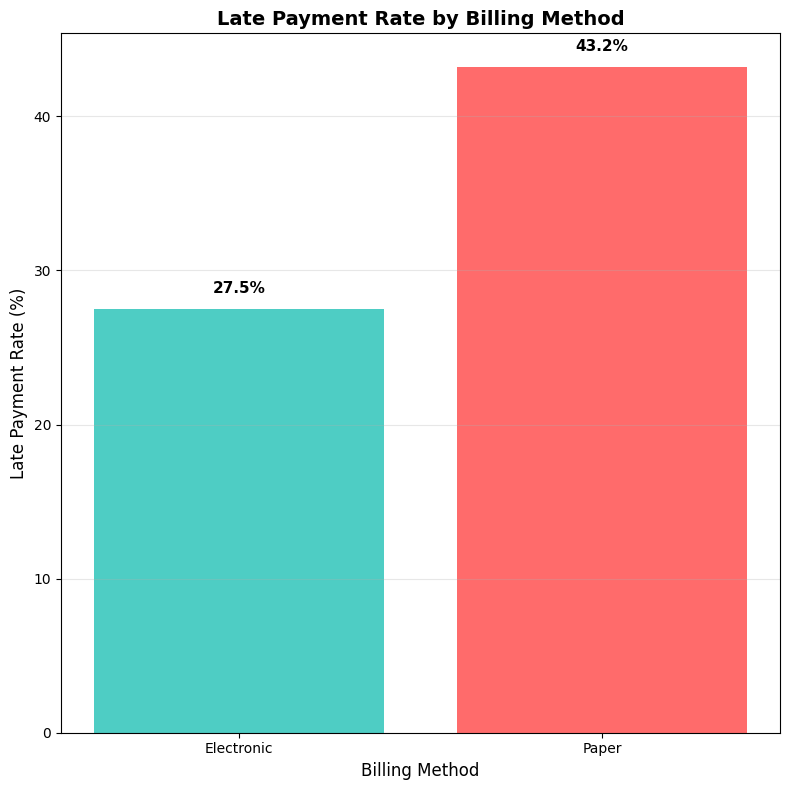

In [26]:
late_by_billing = df_model.groupby('PaperlessBill').agg({
    'IsLate': ['mean', 'sum', 'count']
}).reset_index()
late_by_billing.columns = ['BillingMethod', 'LateRate', 'LateCases', 'TotalInvoices']

plt.figure(figsize=(8, 8))
plt.bar(late_by_billing['BillingMethod'], late_by_billing['LateRate'] * 100,
        color=['#4ECDC4', '#FF6B6B', '#95E1D3'])
plt.ylabel('Late Payment Rate (%)', fontsize=12)
plt.xlabel('Billing Method', fontsize=12)
plt.title('Late Payment Rate by Billing Method', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for i, rate in enumerate(late_by_billing['LateRate'] * 100):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()




### 3.6 Invoice Amount Distribution Analysis

Analyzing if larger invoices are more likely to be paid late where a split violin plot shows invoice amount distributions for on-time vs late payments and electronic vs paper billing. After understanding the relationship, setting appropriate credit limits and payment terms.


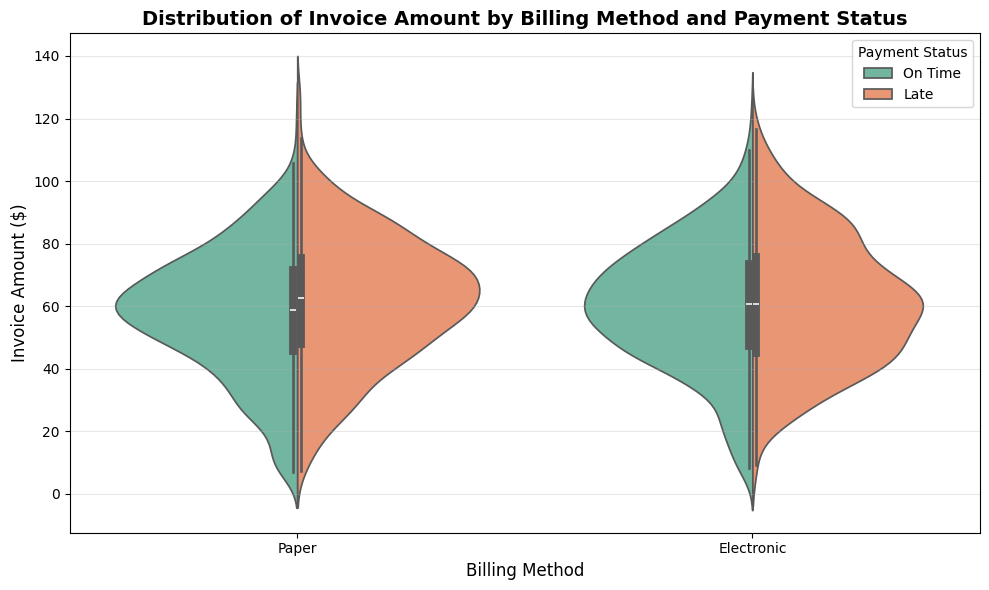

In [27]:
plt.figure(figsize=(10, 6))

df_violin = df_model.copy()
df_violin['PaymentStatus'] = df_violin['IsLate'].map({0: 'On Time', 1: 'Late'})

df_violin = df_violin[df_violin['PaperlessBill'].isin(['Electronic', 'Paper'])].copy()

sns.violinplot(data=df_violin, x='PaperlessBill', y='InvoiceAmount',
               hue='PaymentStatus', split=True, palette='Set2')
plt.ylabel('Invoice Amount ($)', fontsize=12)
plt.xlabel('Billing Method', fontsize=12)
plt.title('Distribution of Invoice Amount by Billing Method and Payment Status',
          fontsize=14, fontweight='bold')
plt.legend(title='Payment Status')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
df_final = df_model.copy()

df_final['days_paperless_to_invoice'] = (df_final['InvoiceDate'] - df_final['PaperlessDate']).dt.days

bins = [-np.inf, -180, -90, -30, 0, 30, 90, 180, np.inf]
labels = ['180+ days before', '90-180 days before', '30-90 days before',
          '0-30 days before', '0-30 days after', '30-90 days after',
          '90-180 days after', '180+ days after']
df_final['paperless_timing'] = pd.cut(df_final['days_paperless_to_invoice'],
                                       bins=bins, labels=labels)

date_cols_to_drop = ['PaperlessDate', 'DueDate', 'SettledDate','PaperlessDate_month', 'PaperlessDate_dayofweek','InvoiceDate_month', 'InvoiceDate_dayofweek', 'InvoiceMonthYear', 'invoice_dayofweek_name']
df_final = df_final.drop(columns=date_cols_to_drop, errors='ignore')

df_final = df_final.drop(columns=['days_paperless_to_invoice'], errors='ignore')

df_final.head()

,countryCode,customerID,InvoiceDate,InvoiceAmount,Disputed,PaperlessBill,IsLate,InvoiceMonth,paperless_timing
0,818,6627-ELFBK,2012-01-06,47.07,Yes,Paper,0,1,180+ days before
2,770,0706-NRGUP,2013-10-05,35.70,No,Electronic,0,10,90-180 days after
3,770,2026-XLBER,2012-04-24,60.93,No,Paper,0,4,180+ days before
4,391,3569-VJWXS,2013-05-15,35.23,No,Electronic,0,5,30-90 days after
5,897,3271-YDPUJ,2012-04-08,76.71,Yes,Paper,1,4,180+ days before


## 4. Model Training

### 4.1 Train/Test Split with Historical Features

Creating historical customer features including hist_late_rate (percentage of past late invoices), hist_invoice_count (customer tenure), hist_dispute_rate (percentage of past disputes), and hist_avg_invoice (average amount) where statistics are calculated using expanding windows with shift(1) to ensure only past invoices are visible. After calculating these features on the training data first, applying the statistics to the test data because this prevents data leakage by replicating real-world deployment where only past behavior is known.


In [29]:
RANDOM_STATE = 42

train_indices, test_indices = train_test_split(
    df_final.index, test_size=0.2, random_state=RANDOM_STATE, stratify=df_final['IsLate']
)

df_train = df_final.loc[train_indices].copy()
df_test = df_final.loc[test_indices].copy()

df_train = df_train.sort_values(['customerID', 'InvoiceDate']).reset_index(drop=True)
df_test = df_test.sort_values(['customerID', 'InvoiceDate']).reset_index(drop=True)

def calculate_historical_features(group):
    group = group.copy()
    group['hist_late_rate'] = group['IsLate'].expanding().mean().shift(1)
    group['hist_invoice_count'] = group.expanding().count()['IsLate'].shift(1)
    group['hist_dispute_rate'] = (group['Disputed'] == 'Yes').expanding().mean().shift(1)
    group['hist_avg_invoice'] = group['InvoiceAmount'].expanding().mean().shift(1)

    fill_cols = [col for col in group.columns if col.startswith('hist_')]
    group[fill_cols] = group[fill_cols].fillna(0)
    return group

df_train = df_train.groupby('customerID', group_keys=False).apply(calculate_historical_features)

customer_stats = df_train.groupby('customerID').agg({
    'IsLate': 'mean',
    'InvoiceAmount': 'mean',
    'Disputed': lambda x: (x == 'Yes').mean()
}).reset_index()

customer_stats.columns = ['customerID', 'train_late_rate', 'train_avg_invoice', 'train_dispute_rate']
customer_stats['train_invoice_count'] = df_train.groupby('customerID').size().values

df_test = df_test.merge(customer_stats, on='customerID', how='left')

df_test['hist_late_rate'] = df_test['train_late_rate'].fillna(0)
df_test['hist_invoice_count'] = df_test['train_invoice_count'].fillna(0)
df_test['hist_dispute_rate'] = df_test['train_dispute_rate'].fillna(0)
df_test['hist_avg_invoice'] = df_test['train_avg_invoice'].fillna(df_train['InvoiceAmount'].mean())

df_test = df_test.drop(columns=['train_late_rate', 'train_invoice_count',
                                  'train_dispute_rate', 'train_avg_invoice'])

df_train['is_new_customer'] = (df_train['hist_invoice_count'] == 0).astype(int)
df_test['is_new_customer'] = (df_test['hist_invoice_count'] == 0).astype(int)

drop_cols = ['IsLate', 'customerID', 'InvoiceDate', 'PaperlessDate']
X_train = df_train.drop(columns=drop_cols, errors='ignore')
X_test = df_test.drop(columns=drop_cols, errors='ignore')
y_train = df_train['IsLate']
y_test = df_test['IsLate']

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"Train late rate: {y_train.mean():.2%}")
print(f"Test late rate: {y_test.mean():.2%}")

Train size: 1972
Test size: 494
Train late rate: 35.55%
Test late rate: 35.63%


/tmp/ipython-input-627125327.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('customerID', group_keys=False).apply(calculate_historical_features)


### 4.2 Linear Regression
Serving as a baseline, interpretable model for late payment prediction. A custom probability threshold of 0.4 is applied to prioritize recall and reduce missed late invoices.

Logistic Regression provides transparent, coefficient-based explanations and allows business-driven threshold tuning to align model outputs with risk tolerance.

In [30]:
LR_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
LR_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [31]:
threshold = 0.4

y_pred_proba = LR_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)

accuracy_LR = accuracy_score(y_test, y_pred)
precision_LR = precision_score(y_test, y_pred)
recall_LR = recall_score(y_test, y_pred)
f1_LR = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Threshold: {threshold}")
print(f"Accuracy: {accuracy_LR:.4f}")
print("\nClassification Report:")
print(report)

cm_LR = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm_LR)

Threshold: 0.4
Accuracy: 0.8684

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       318
           1       0.83      0.79      0.81       176

    accuracy                           0.87       494
   macro avg       0.86      0.85      0.85       494
weighted avg       0.87      0.87      0.87       494


Confusion Matrix:
[[290  28]
 [ 37 139]]


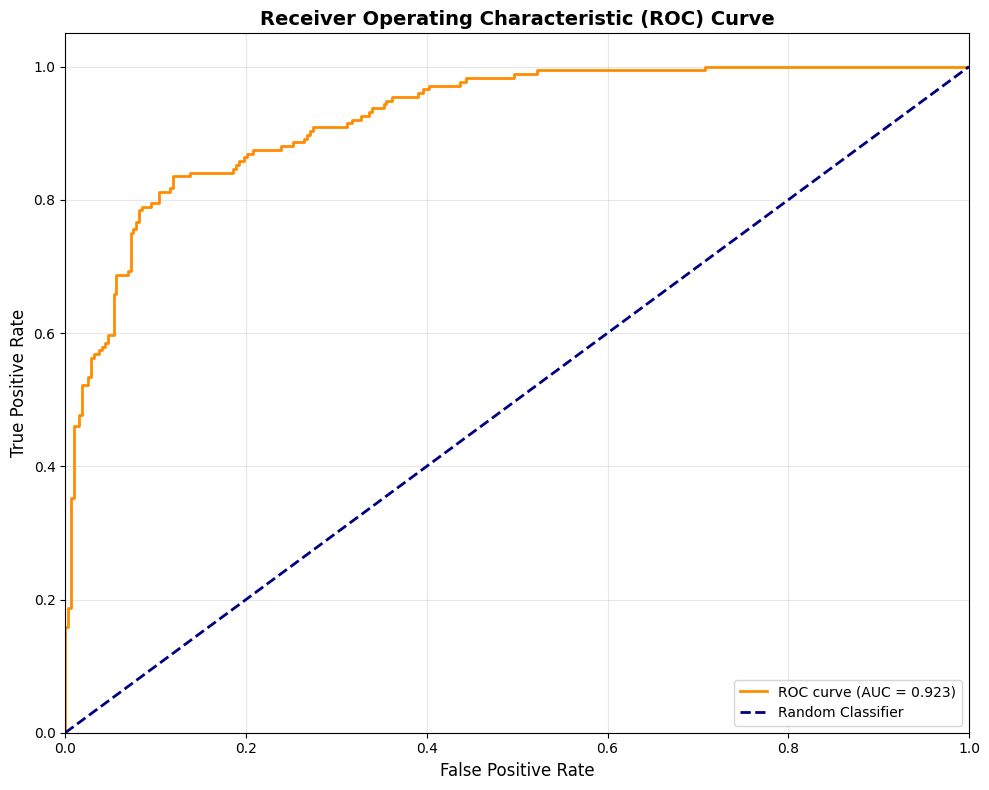

AUC Score: 0.9233


In [32]:
y_pred_proba = LR_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

### 4.3 Decision Tree

Capturing non-linear relationships while maintaining interpretability. The configuration uses max_depth=5 to prevent overfitting while allowing complexity, and the tree is visualized to show decision rules.

Decision Trees handle non-linear patterns, automatically model feature interactions, and are easy to explain to stakeholders. This makes them useful when the business needs to understand why a prediction was made.


In [33]:
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

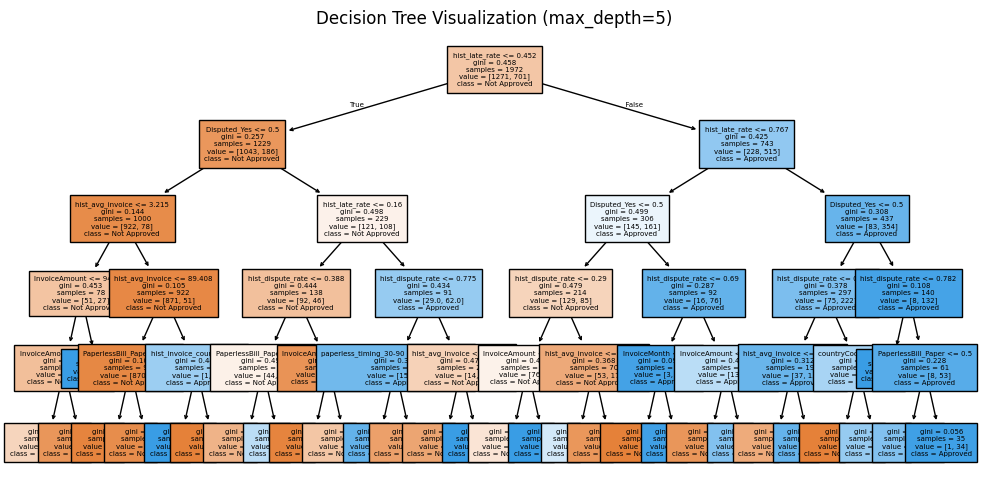

In [34]:
threshold = 0.4

y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]
y_pred_dt = (y_pred_proba_dt >= threshold).astype(int)


plt.figure(figsize=(10, 5))
plot_tree(dt_model, feature_names=X_train.columns, class_names=['Not Approved', 'Approved'],
          filled=True, fontsize=5, max_depth=5)
plt.title('Decision Tree Visualization (max_depth=5)')
plt.tight_layout()
plt.show()

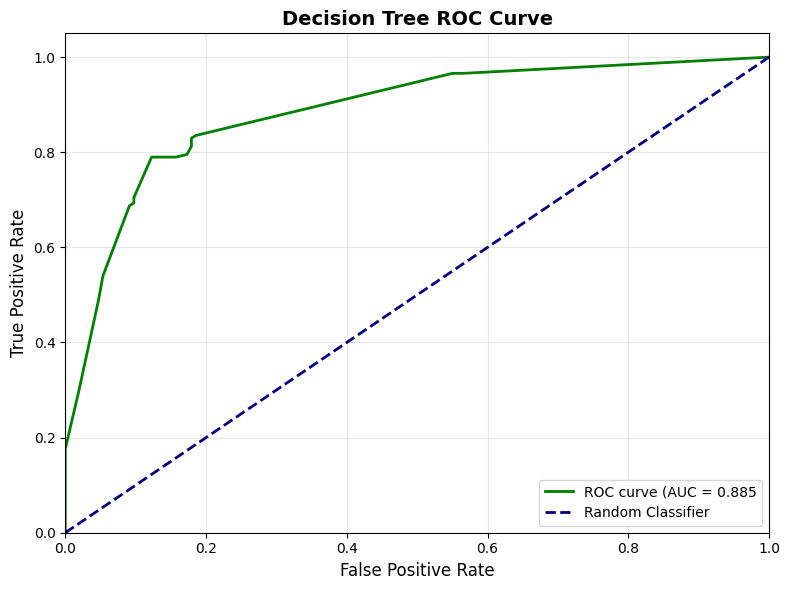

Decision Tree AUC Score: 0.8854


In [35]:
pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_dt:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Decision Tree ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Decision Tree AUC Score: {roc_auc_dt:.4f}")

In [36]:


accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

cm_DT = confusion_matrix(y_test, y_pred_dt)

print("\nConfusion Matrix:")
print(cm_DT)

Decision Tree Accuracy: 0.8462

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       318
           1       0.78      0.79      0.79       176

    accuracy                           0.85       494
   macro avg       0.83      0.83      0.83       494
weighted avg       0.85      0.85      0.85       494


Confusion Matrix:
[[279  39]
 [ 37 139]]


### 5.3 Decision Tree Feature Importance

Understanding which features drive predictions helps generate business insights about what factors most influence late payments, enables feature selection by focusing on high-impact variables, and validates that the model learns sensible patterns.

Expected top features include historical payment rate (customer behavior), invoice amount (larger invoices more likely late), and customer tenure (new customers are riskier).



Top 10 Most Important Features:
                              feature  importance
3                      hist_late_rate    0.639802
8                        Disputed_Yes    0.180592
5                   hist_dispute_rate    0.056551
6                    hist_avg_invoice    0.052784
1                       InvoiceAmount    0.030147
9                 PaperlessBill_Paper    0.015635
0                         countryCode    0.010661
14  paperless_timing_30-90 days after    0.007380
2                        InvoiceMonth    0.003733
4                  hist_invoice_count    0.002715


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

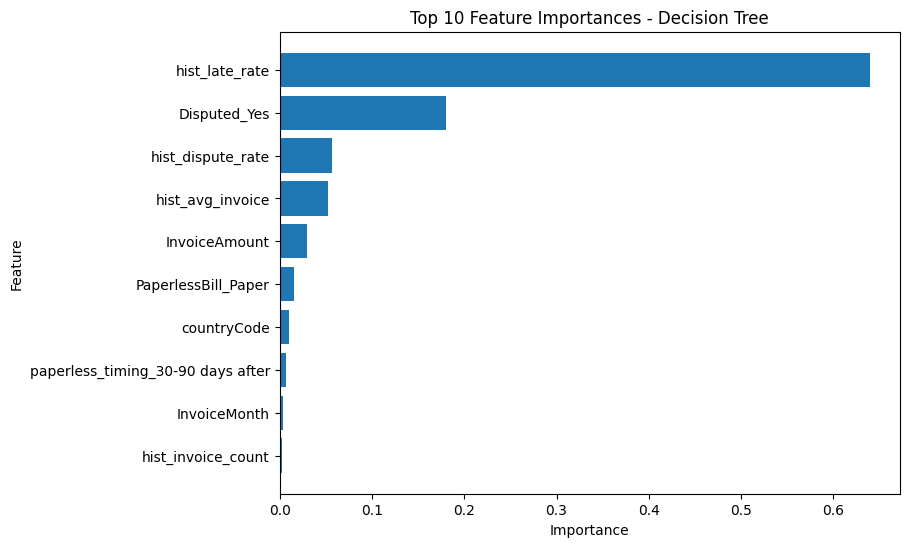

In [37]:
feature_importance_dt = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_dt.head(10))

plt.figure(figsize=(8, 6))
plt.barh(feature_importance_dt.head(10)['feature'], feature_importance_dt.head(10)['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout

### 4.4 Random Forest with SMOTE

The dataset is imbalanced with approximately 70% on-time payments and 30% late payments. SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic late payment examples to balance classes.

SMOTE is applied only to training data to prevent data leakage and balances classes to a 50/50 split, which improves the model's ability to learn minority class patterns.

The Random Forest configuration uses 100 decision trees (n_estimators=100), allows deeper trees than a single tree (max_depth=10) for better performance, and averages predictions across all trees to reduce overfitting.

This approach is expected to produce the best performance, especially on Recall for catching late payments.


In [38]:
!pip install imblearn

print("Applying SMOTE to training data...")
sm = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}, {y_train.shape}")
print(f"SMOTE training set shape: {X_train_smote.shape}, {y_train_smote.shape}")
print(f"Original y_train class distribution:\n{y_train.value_counts()}")
print(f"SMOTE y_train class distribution:\n{y_train_smote.value_counts()}")

Applying SMOTE to training data...
Original training set shape: (1972, 17), (1972,)
SMOTE training set shape: (2542, 17), (2542,)
Original y_train class distribution:
IsLate
0    1271
1     701
Name: count, dtype: int64
SMOTE y_train class distribution:
IsLate
0    1271
1    1271
Name: count, dtype: int64


In [39]:
rf_model_smote = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, max_depth=10)
rf_model_smote.fit(X_train_smote, y_train_smote)

y_pred_rf_smote = rf_model_smote.predict(X_test)
y_pred_proba_rf_smote = rf_model_smote.predict_proba(X_test)[:, 1]

accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
precision_rf_smote = precision_score(y_test, y_pred_rf_smote)
recall_rf_smote = recall_score(y_test, y_pred_rf_smote)
f1_rf_smote = f1_score(y_test, y_pred_rf_smote)
report_rf_smote = classification_report(y_test, y_pred_rf_smote)
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)

print(f"Random Forest (SMOTE) Accuracy: {accuracy_rf_smote:.4f}")
print("\nClassification Report (SMOTE):")
print(report_rf_smote)
print("\nConfusion Matrix (SMOTE):")
print(cm_rf_smote)

Random Forest (SMOTE) Accuracy: 0.8623

Classification Report (SMOTE):
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       318
           1       0.81      0.80      0.81       176

    accuracy                           0.86       494
   macro avg       0.85      0.85      0.85       494
weighted avg       0.86      0.86      0.86       494


Confusion Matrix (SMOTE):
[[285  33]
 [ 35 141]]


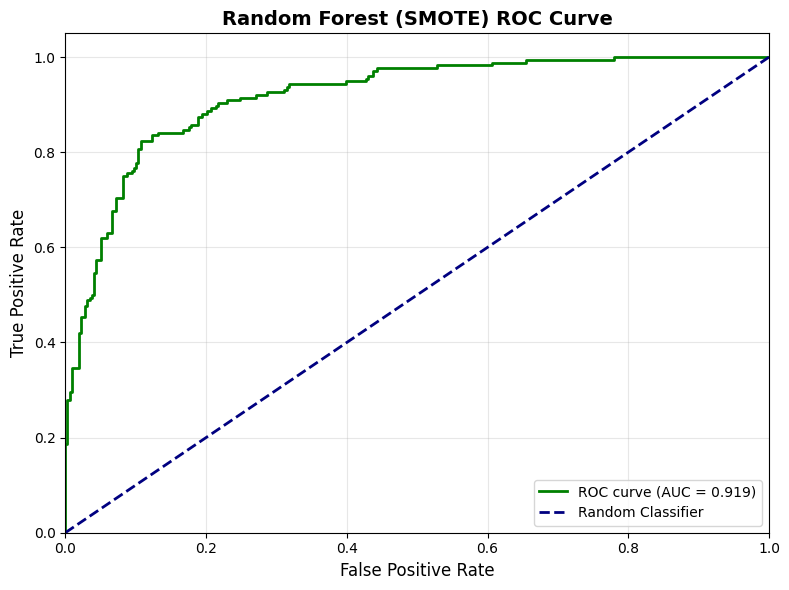

Random Forest (SMOTE) AUC Score: 0.9185


In [40]:
fpr_rf_smote, tpr_rf_smote, thresholds_rf_smote = roc_curve(y_test, y_pred_proba_rf_smote)
roc_auc_rf_smote = roc_auc_score(y_test, y_pred_proba_rf_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_smote, tpr_rf_smote, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_rf_smote:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest (SMOTE) ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Random Forest (SMOTE) AUC Score: {roc_auc_rf_smote:.4f}")

## 5. Model Comparison




### 5.1 ROC Curve Comparison
Plotting all three models on the same chart allows direct performance comparison. The analysis looks for which curve is furthest from the diagonal (random classifier), which has the highest AUC, and whether differences are meaningful or within margin of error.

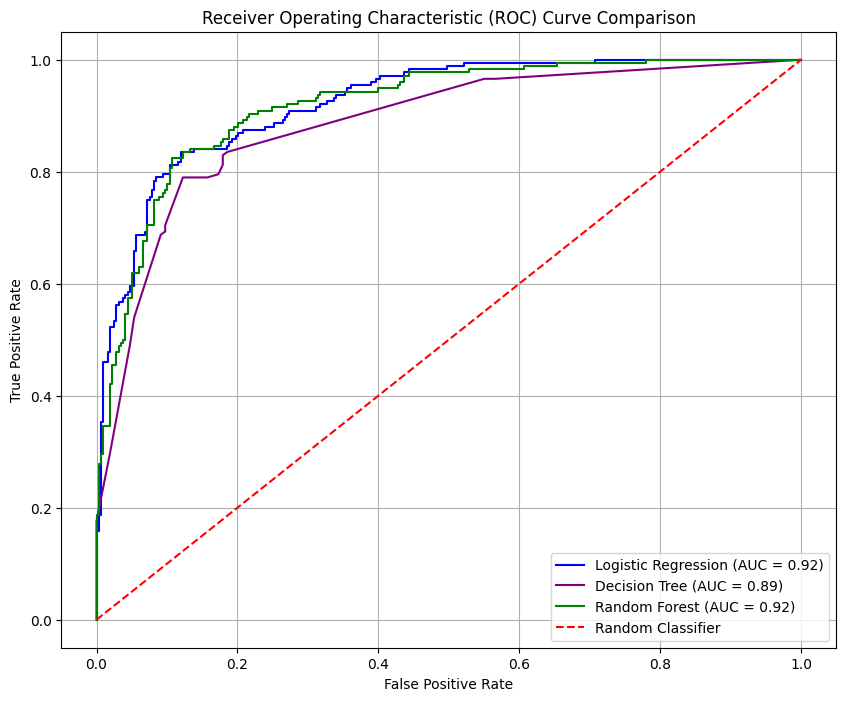

In [41]:
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')

plt.plot(fpr_dt, tpr_dt, color='purple', label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

plt.plot(fpr_rf_smote, tpr_rf_smote, color='green', label=f'Random Forest (AUC = {roc_auc_rf_smote:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

### 5.2 Comprehensive Metrics Comparison

Plotting all three models on the same chart allows for direct comparison, highlighting which model’s curve sits furthest from the random classifier, delivers the highest AUC, and shows performance differences that are practically meaningful rather than within margin of error.



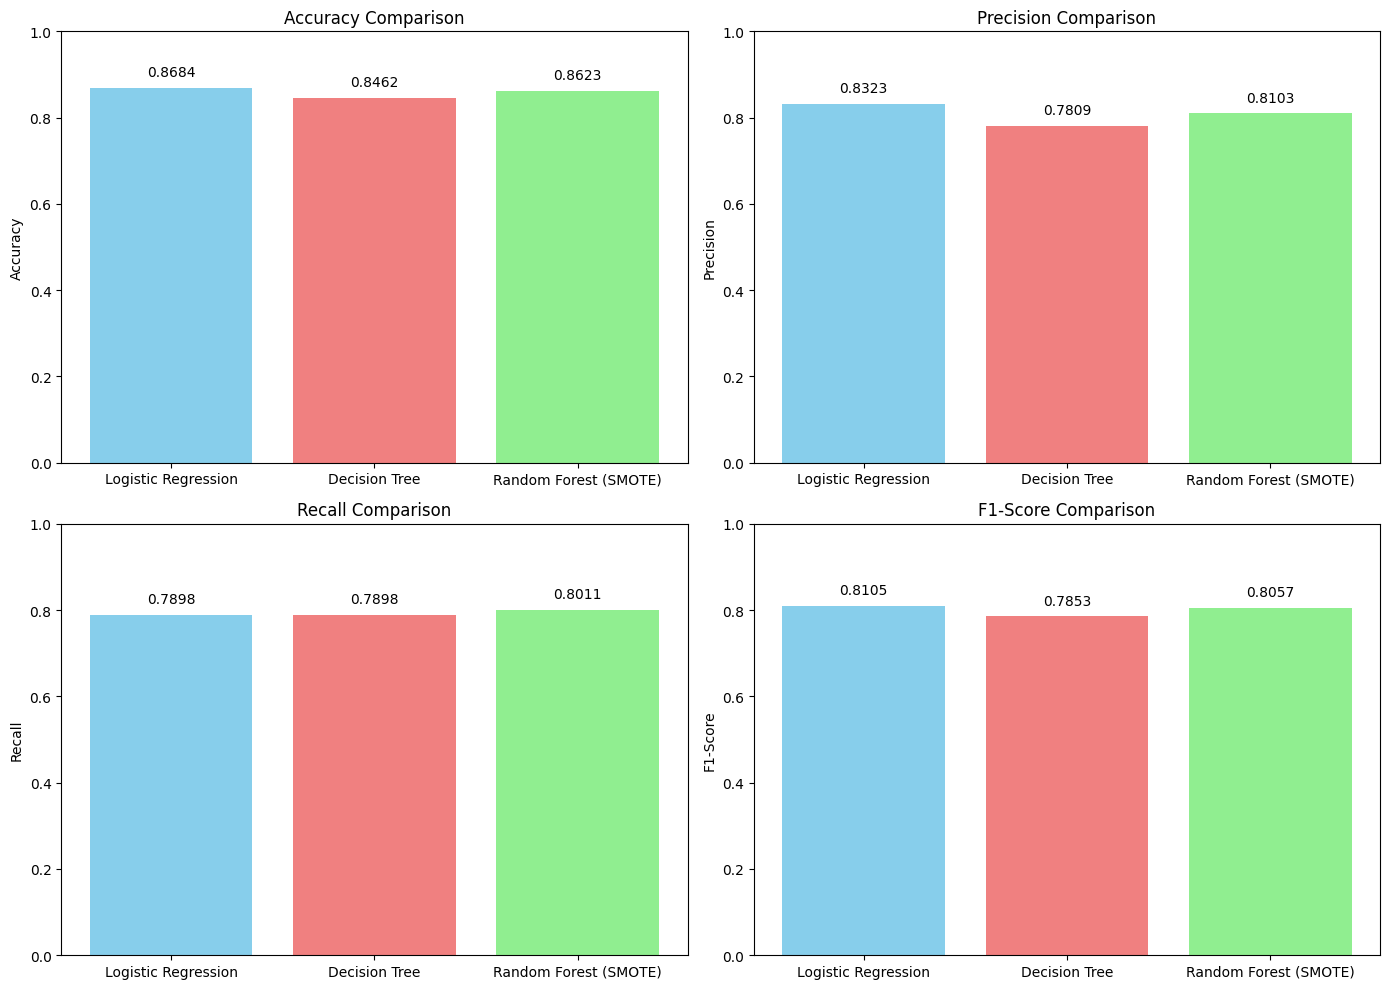

In [42]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest (SMOTE)']

accuracy_scores = [accuracy_LR, accuracy_dt, accuracy_rf_smote]
precision_scores = [precision_LR, precision_dt, precision_rf_smote]
recall_scores = [recall_LR, recall_dt, recall_rf_smote]
f1_scores = [f1_LR, f1_dt, f1_rf_smote]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics_data = {
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores
}

for i, (metric_name, scores) in enumerate(metrics_data.items()):
    ax = axes[i]
    bars = ax.bar(models, scores, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax.set_title(f'{metric_name} Comparison')
    ax.set_ylabel(metric_name)
    ax.set_ylim(0, 1)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Executive Summary

The goal of this project was to create a model capable of predicting invoice payments that would arrive late. Three models were trained and evaluated, with Logistic Regression and Random Forest with SMOTE emerging as the most effective approaches. Based on comparative analysis, **Logistic Regression is the recommended model** due to its slightly higher accuracy, precision, and F1-score, as well as its easier interpretability compared to Random Forest.

### Final Model Performance
- **Accuracy:** ~87%
- **F1-Score:** 0.81
- **AUC:** 0.92

These are impressive metrics that indicate the model should perform well in a production environment.

## Methodology Highlights

The model's main success came from its ability to leverage historical customer data to predict late payments. By splitting the data and calculating aggregated customer statistics, we significantly boosted the model's predictive power without introducing data leakage. This approach ensures that the model should perform similarly on new data outside the test set, maintaining its reliability in real-world applications.

## Limitations & Considerations

### New Customer Challenge
When encountering new customers without historical data, the model may not be as effective at predicting late payment rates. This is an inherent limitation of the customer-history-based approach.

### Trend Analysis
An important consideration for implementation is the observed trend of decreasing late payment rates over time. If this trend continues, it may be worth re-evaluating the model to ensure it doesn't rely too heavily on historical data that no longer reflects current payment behaviors. Regular model retraining should be considered to maintain optimal performance.

## Business Applications & Future Work

### Primary Use Case: Cash Flow Optimization
The immediate benefit of implementing this model is improved cash flow forecasting. By accurately predicting which invoices are likely to be paid late, the company can:
- Better manage working capital
- Make more informed decisions about credit extensions
- Optimize collection efforts by prioritizing high-risk accounts

### Extended Application: Bad Debt Prediction
This model framework could be adapted for additional use cases. A particularly valuable extension would be predicting which invoices are likely not just to be late, but to ultimately be written off as uncollectible. This enhanced model could:
- Improve accuracy of the allowance for doubtful accounts
- Optimize bad debt write-offs for tax purposes
- Enhance financial reporting accuracy
- Enable more proactive account management

### Future Enhancements
With additional time and data, this model could be further developed to:
- Incorporate real-time payment behavior updates
- Add industry-specific risk factors
- Develop customer segmentation strategies
- Create automated intervention triggers for at-risk accounts

## Conclusion

The invoice payment prediction model demonstrates strong performance and practical business value. While limitations exist around new customer predictions and evolving payment trends, the model provides a solid foundation for improved financial planning and risk management. With thoughtful implementation and periodic refinement, this tool can deliver significant value to the organization's financial operations.